**Thực Hành 07: Wasserstein GAN with gradient penalty (WGAN-GP)**

* Trong DCGAN quá trình huấn luyện discriminator sẽ tạo ra những thông tin tốt để cải thiện generator nhưng generator lại không thực hiện tốt vai trò của mình khiến cho giá trị gradient descent của nó thường bị triệt tiêu và generator không học được gì (Vanishing Gradient).Do đó WGAN ra đời để giải quyết vấn đề hội tụ cho hàm loss trong generator.

* Do đó Arjovsky et al 2017  đã cho cộng thêm noise $\epsilon$ ~ N(0,1) cho nhãn của ảnh giả và ảnh thật trong model discriminator (Bài thực hành trước có  trick cộng vào, có thể xem lại dòng code đó) để làm cho  mô hình ổn đinh hơn

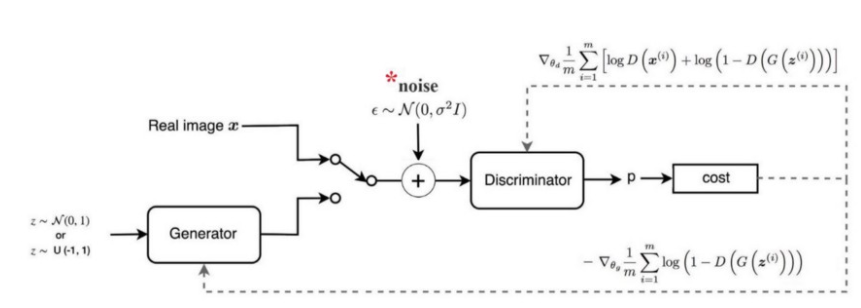











* Thay vì cộng  thêm noise vào, Wasserstein GAN đưa chúng ta một cách tiếp cận khác là dùng khoảng cách Wasserstein. cho cả loss function của generator và discriminator. và biến w trong discriminator phải được clipped trong đoạn [-c,c] cho trước

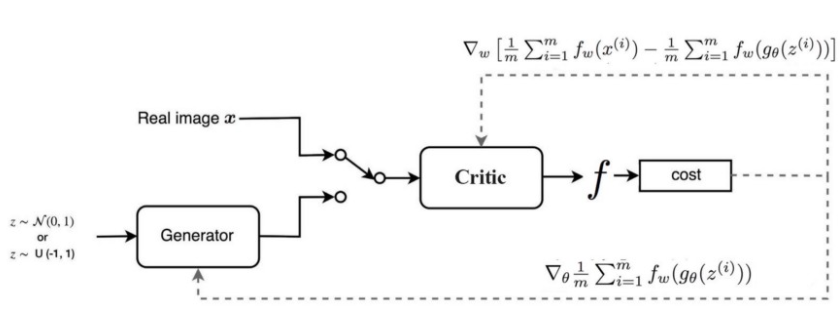

* Tuy nhiên WGAN vẫn gặp vấn đề nếu trong critic (discriminator) chọn c quá lớn, khi đó có thể mất rất lâu để trọng số w hội tụ được, từ đây sẽ ảnh hưởng đến việc huấn luyện critic. Nếu c quá nhỏ, có thể dẫn đến mô hình dễ dàng bị vanishing gradient khi có quá nhiều layers 

* WGAN-GP sẽ giống với WGAn tuy nhiên sẽ có thêm một hàm penalty để phạt với penalty_function = $ (||\nabla_{x'}D_w(x')||_2-1)^2$. Với x' là ảnh nội suy. x'=${\epsilon}(ảnh thật -ảnh giả) +ảnh giả$

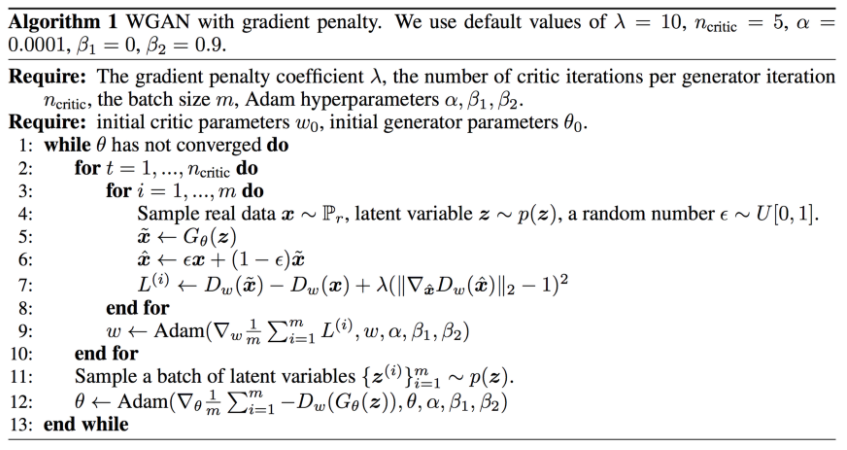

**Tóm lại**

Ta cần lưu ý sau: 
* Discriminator sẽ đổi lại thành critic, và đây không phải là mô hình phân loại mà là một mô hình đánh giá chất lượng của ảnh, do đó không dùng softmax ở layer cuối
* sẽ có thêm một hàm penalty để đánh lỗi cho critic
* trong mỗi batch quá trình huấn luyện của critic sẽ thêm khoảng 5 vòng lặp 
* loss function cho critic là ảnh thật - ảnh giả (chấp nhận)[1]ư
* loss function cho critic là ảnh giả (chấp nhận) [2]
[1], [2] https://arxiv.org/abs/1704.00028v3


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
batch_size = 1024
# Size of the noise vector
noise_dim = 128

batch_size = 128 # batch size để đưa vào mô hình huấn luyện
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() #đọc dữ liệu
all_digits = np.concatenate([x_train, x_test]) 
all_digits = (all_digits.astype("float32")-127.5) / 127.5 #đưa tấm hình về [-1,1]
all_digits = np.reshape(all_digits,(-1,28,28,1)) #reshape toàn bộ dữ liệu lại
dataset=tf.data.Dataset.from_tensor_slices(all_digits) #Đưa dữ liệu về dạng tensor
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32) #shuffle dữ liệu mỗi lần đưa vào mô hình

11493376/11490434 [==============================] - 0s 0us/step


Nên Tạo một block nếu các layers lặp lại

In [ ]:
def conv_block(    #Tạo một convolution block
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn: #Dùng bathcnorm hay không
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:  #Có dùng dropout hay không
        x = layers.Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = layers.Input(shape=(28,28,1))
    # pad input thành (32, 32, 1).
    x = layers.ZeroPadding2D((2, 2))(img_input)
    x = conv_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 128)       

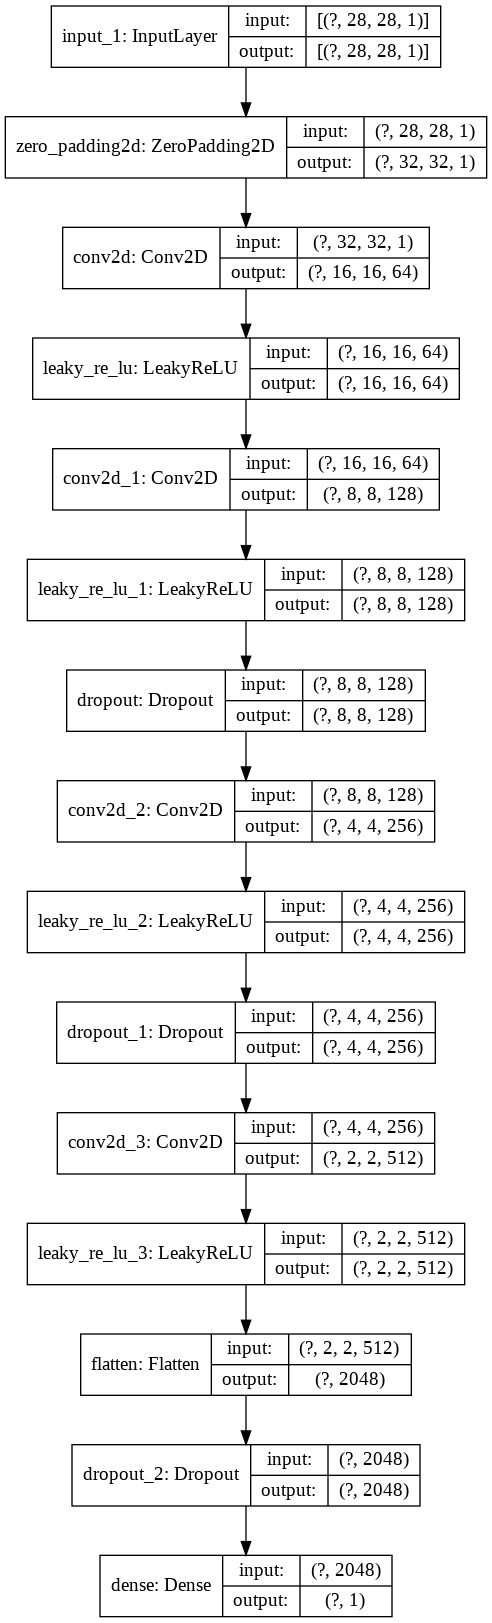

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(d_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 1, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    #crop output thành (28,28,1)
    x = layers.Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()


Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              524288    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         29

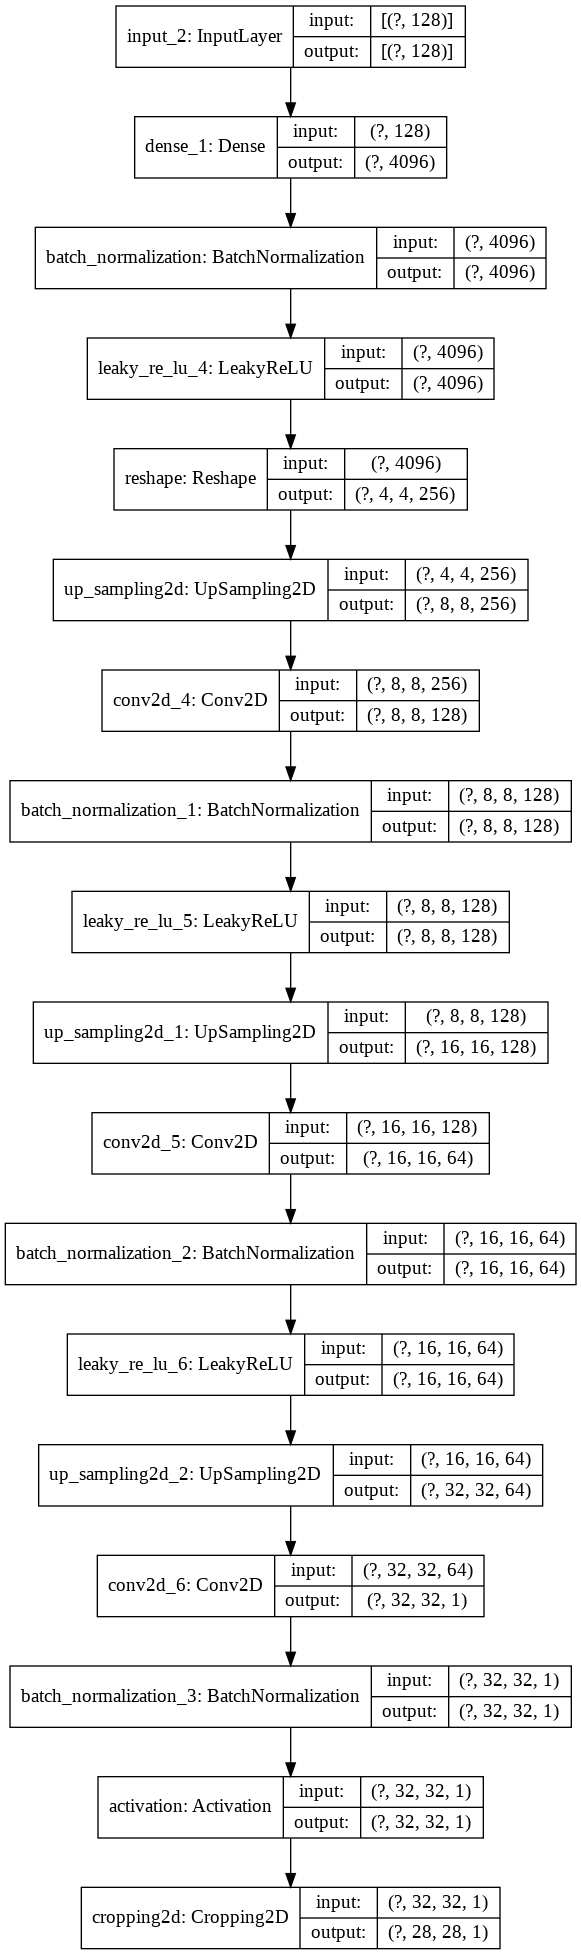

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(g_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator # model discriminator 
        self.generator = generator         # model generator
        self.latent_dim = latent_dim       # số chiều noise
        self.d_steps = discriminator_extra_steps # số bước lặp thêm cho critic (discriminator)
        self.gp_weight = gp_weight               # alpha trong thuật toán

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer #optimizer cho critic
        self.g_optimizer = g_optimizer #optimizer cho generator
        self.d_loss_fn = d_loss_fn     #loss function critic
        self.g_loss_fn = g_loss_fn     #loss function gen

    def gradient_penalty(self, batch_size, real_images, fake_images):  #này là hàm lỗi để đánh thêm cho discriminator dựa trên ảnh nội suy
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Tạo một ảnh nội suy
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. đánh giá một ảnh
            pred = self.discriminator(interpolated, training=True)

        # 2. Tính đạo hàm
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # Với mỗi batch ta tiến hành theo bài báo gốc như sau:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

In [ ]:
from IPython.display import Image, display
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5
        print("epoch ",epoch)

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.preprocessing.image.array_to_img(img)
            display(img)

In [ ]:
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)


def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img) 
    fake_loss = tf.reduce_mean(fake_img) 
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


In [ ]:
epochs = 20

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3
)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss
)

# Start training the model.
wgan.fit(dataset, epochs=epochs, callbacks=[cbk],verbose=0)

#Bài Tập
* Từ mạng WGAN trên hãy viết thử một mạng CWGAN